In [1]:
pip install pydicom pandas matplotlib numpy opencv-python tensorflow

Note: you may need to restart the kernel to use updated packages.


In [68]:
import pydicom as dicom
import pandas as pd
import os

data_dir = 'train/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('_labels.csv')
labels_df.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [69]:
i = 0
for patient in patients[:3]:
    label = labels_df._get_value(int(patient),'MGMT_value')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s + '/' + c) for s in os.listdir(path)
        for c in os.listdir(path+'/'+s)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print('(', i,')', len(slices), slices[0].pixel_array.shape)
    i+=1

( 0 ) 970 (512, 512)
( 1 ) 673 (512, 512)
( 2 ) 699 (512, 512)


In [71]:
len(patients)

585

0


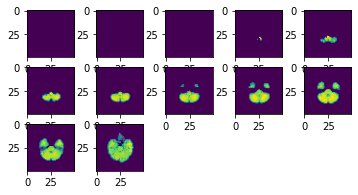

C:\Users\mkrizek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [77]:
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import math

IMG_PX_SIZE = 50
HM_SLICES = 20

def chunks (l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
    
def mean(l):
    return sum(l)/len(l)


def process_data(patient, labels_df, img_px_size=50, hm_slices=20, visualize=False):
    # Reading in the labels into a dataframe
    label = labels_df._get_value(int(patient), 'MGMT_value')

    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s + '/' + c) for s in os.listdir(path)
        for c in os.listdir(path+'/'+s)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))    
    
    
    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array), (IMG_PX_SIZE, IMG_PX_SIZE)) for each_slice in slices]    
    
    # Calculating the chunk size to produce HM_SLICES
    chunk_size = math.ceil(len(slices)/HM_SLICES)
    
    # Iterating through the slices and creating chunks
    for slice_chunk in chunks(slices, chunk_size):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    while len(new_slices) < HM_SLICES:
        new_slices.append(new_slices[-1])
        
    # Averaging the last slice (if it is larger than the expected # of slices) into the 2nd
    # to last slice.
    if len(new_slices) == HM_SLICES + 2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1], new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    # Averaging the last slice (if it is larger than the expected # of slices) into the 2nd
    # to last slice.
    if len(new_slices) == HM_SLICES + 2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1], new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    # Allows for small subsections of the data to be graphed out.    
    if visualize:
        fig = plt.figure()
        for num, each_slice in enumerate(slices[:12]):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice)
        plt.show()
        
    
    # Creating the one-hot array values for the dataset    
    if label == 1: 
        label = np.array([0,1])
            
    elif label == 0: 
        label = np.array([1,0])
        
    return np.array(new_slices), label



large_data = []

for num, patient in enumerate(patients):
    # Making sure that progress is being made.
    if num%50==0:
        print(num)
        
    try:
        img_data,label = process_data(patient, labels_df, img_px_size=IMG_PX_SIZE, hm_slices=HM_SLICES, visualize=True)
        large_data.append([img_data, label])
    # When a lebel does not exist for a patient, print it out    
    except KeyError as e:
        print(patient, 'this is unlabeled data')
        
np.save('processedData-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), large_data)
        

MODEL

In [76]:
import tensorflow.compat.v1 as tf
import numpy as np

tf.disable_v2_behavior() 

IMG_PX_SIZE = 50
HM_SLICES = 20

num_classes = 2

x = tf.compat.v1.placeholder('float')#, [NONE, 20, 50, 50])
y = tf.compat.v1.placeholder('float')

keep_rate = 0.8
keep_prob = tf.compat.v1.placeholder(tf.float32)

load_data = np.load('processedData-50-50-20.npy', allow_pickle=True)
train_data = load_data[:-100]
validation_data = load_data[-100:]

def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')



def convolutional_neural_network(x):
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, num_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([num_classes]))}

    x = tf.reshape(x, shape=[-1, IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)
    
    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

def train_neural_network(x):
    
    
    print(pd.DataFrame(load_data).describe())
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y) )
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    hm_epochs = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        success_total = 0
        attempt_total = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                attempt_total += 1
                try:
                    X = data[0]
                    Y = data[1]

                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    success_total += 1
                except Exception as e:
                    pass

            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss, 'success rate:', success_total/attempt_total)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y))
            #print(correct)

            accuracy = tf.compat.v1.reduce_mean(tf.compat.v1.cast(correct, 'float'))
            #print(accuracy)
            z = []
            t = []
            iterator = 0
            total_accuracy = 0
            for i in validation_data:
                z.append(i[0])
                t.append(i[1])
                total_accuracy += accuracy.eval({x:i[0], y:i[1]})
                iterator += 1


            print('Accuracy:', total_accuracy/iterator)
            
        total_accuracy = 0
        iterator = 0
        for i in validation_data:
            z.append(i[0])
            t.append(i[1])
            total_accuracy += accuracy.eval({x:i[0], y:i[1]})
            iterator += 1


        print('Overall Accuracy:', total_accuracy/iterator)

train_neural_network(x)

                                                        0       1
count                                                 403     403
unique                                                403     403
top     [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  [0, 1]
freq                                                    1       1
Epoch 1 completed out of 20 loss: 35028543312.0 success rate: 1.0
Accuracy: 0.56
Epoch 2 completed out of 20 loss: 14897614180.0 success rate: 1.0
Accuracy: 0.5
Epoch 3 completed out of 20 loss: 6138388811.0 success rate: 1.0
Accuracy: 0.53
Epoch 4 completed out of 20 loss: 3041970786.0 success rate: 1.0
Accuracy: 0.49
Epoch 5 completed out of 20 loss: 1934923694.0 success rate: 1.0
Accuracy: 0.46
Epoch 6 completed out of 20 loss: 964650794.5 success rate: 1.0
Accuracy: 0.51
Epoch 7 completed out of 20 loss: 552267369.5 success rate: 1.0
Accuracy: 0.51
Epoch 8 completed out of 20 loss: 453260764.0 success rate: 1.0
Accuracy: 0.49
Epoch 9 completed out of 20 loss

In [29]:
labels_df.MGMT_value.value_counts()

1    307
0    278
Name: MGMT_value, dtype: int64